In [14]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import astropy
from scipy.signal import periodogram

%matplotlib inline

# Parameters of the simulation

We will simulate a pair of 140 GHz LFT detectors. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version vPTEP (**new!**), and we will simulate 6 months of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.


In [3]:
telescope = "LFT"
channel = "L4-140"
detlist = ["000_001_017_QB_140_T", "000_001_017_QB_140_B"]

start_time = astropy.time.Time("2025-01-01T00:00:00")
mission_time_days = 1

imo_version = "vPTEP"

# Resolution of the output maps
nside = 64

To use the IMO bundled in `litebird_sim`, one needs to do the following:


In [4]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    imo=imo,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.


In [5]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

# filling dets with info and detquats with quaternions of the detectors in detlist
dets = []  # type: List[lbs.DetectorInfo]
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )

    # we overwrite the nominal sampling rate read from IMO with a smaller one, so that
    # we produce six months tod without taking too much memory
    det.sampling_rate_hz = 19

    dets.append(det)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The following command will take some time: it needs to compute the ephemerides of the Earth with respect to the Ecliptic reference frame and derive the orientation of the LFT instrument as a function of time for the whole duration of the simulation. This step will be needed later, when we will obtain the pointings for the detectors involved in the simulation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/scanning.html#scanning-strategy) for more details about the scanning strategy.


In [6]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

#### Making TOD with HWP emission and nonlinearity

In [7]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

assert len(sim.observations) == 1

In [9]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.prepare_pointings()

Let's build a sky map and scan it to fill the TOD 

In [16]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

In [17]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
    units="K_CMB",
)

mbs = lbs.Mbs(simulation=sim, parameters=Mbsparams, channel_list=ch_info)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2024-09-13 13:03:39,870 INFO MPI#0000] generating and saving cmb simulations
[2024-09-13 13:03:40,013 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-09-13 13:03:40,014 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-09-13 13:03:40,053 INFO MPI#0000] Access data from /Users/utente/Desktop/litebird_dev/notebooks/.test/cmb/0000/cmb_0000_date_240913.fits
[2024-09-13 13:03:40,056 INFO MPI#0000] NSIDE = 64
[2024-09-13 13:03:40,057 INFO MPI#0000] ORDERING = RING in fits file
[2024-09-13 13:03:40,058 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-09-13 13:03:40,093 INFO MPI#0000] generating and saving fg simulations
[2024-09-13 13:03:40,095 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-09-13 13:03:40,193 INFO MPI#0000] NSIDE = 512
[2024-09-13 13:03:40,194 INFO MPI#0000] ORDERING = RING in fits file
[2024-09-13 13:03:40,194 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-09-13 13:03:40,350 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if n

In [18]:
sim.fill_tods(maps)
sim.add_dipole()
sim.add_noise(random=sim.random)

In [19]:
binner_results = sim.make_binned_map(nside=nside)
binned = binner_results.binned_map

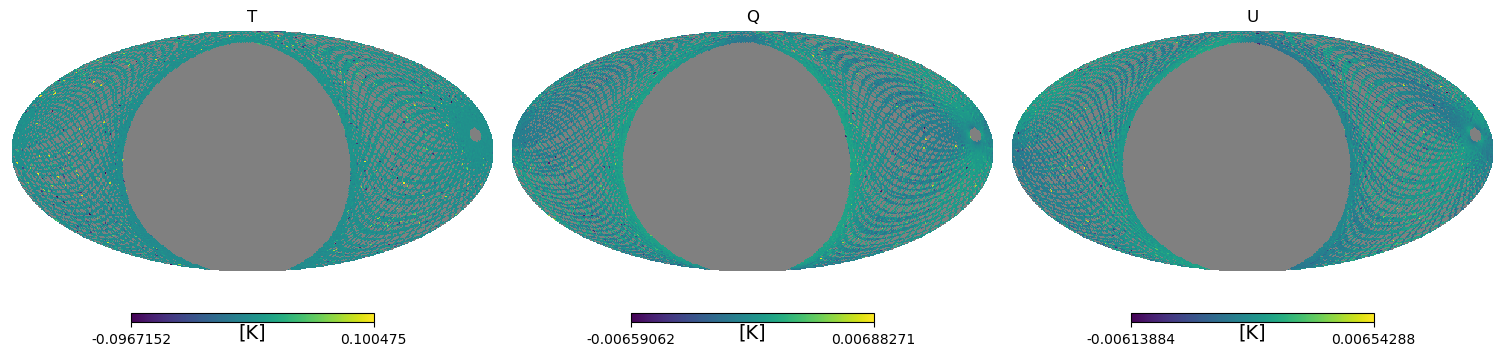

In [20]:
plt.figure(figsize=(15, 8))
hp.mollview(binned[0], sub=131, title="T", unit=r"[K]")
hp.mollview(binned[1], sub=132, title="Q", unit=r"[K]")
hp.mollview(binned[2], sub=133, title="U", unit=r"[K]")

Now we can add the 2f signal with custom parameters

In [21]:
# setting 2f parameters
sim.observations[0].amplitude_k = np.array([0.1, 0.1])
sim.observations[0].monopole_k = np.array([0.0, 0.0])
sim.add_2f()

Let's check our TODs and maps after adding 2f signal

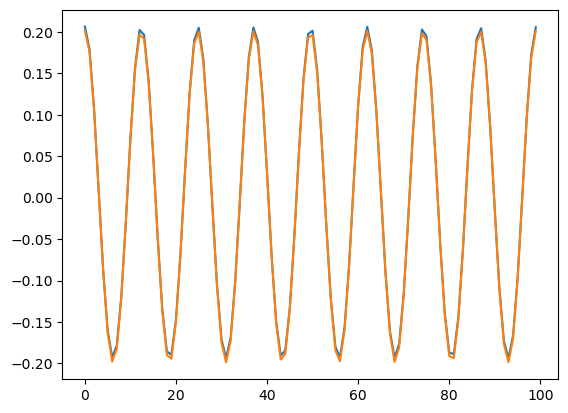

In [22]:
plt.plot(sim.observations[0].tod[0][:100])
plt.plot(sim.observations[0].tod[1][:100])

In [23]:
binner_results = sim.make_binned_map(nside=nside)
binned = binner_results.binned_map

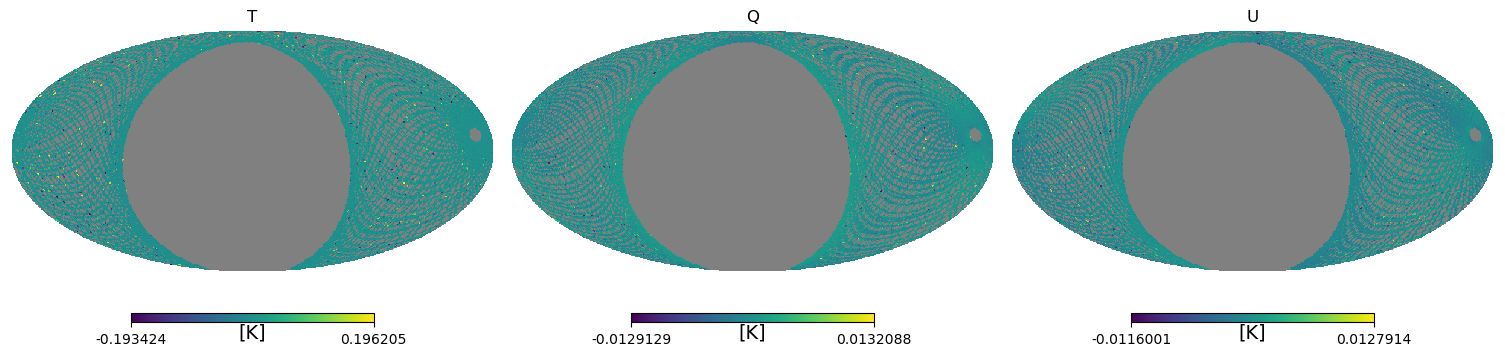

In [24]:
plt.figure(figsize=(15, 8))
hp.mollview(binned[0], sub=131, title="T", unit=r"[K]")
hp.mollview(binned[1], sub=132, title="Q", unit=r"[K]")
hp.mollview(binned[2], sub=133, title="U", unit=r"[K]")

Last step is applying nonlinearity. We choose just one detector, to have a reference for the ideal case

In [26]:
# setting nonlinearity
sim.observations[0].g_one_over_k = np.array([1e-3, 0])
sim.apply_quadratic_nonlin()

Let's check our TODs and maps after applying a quadratic non-linearity

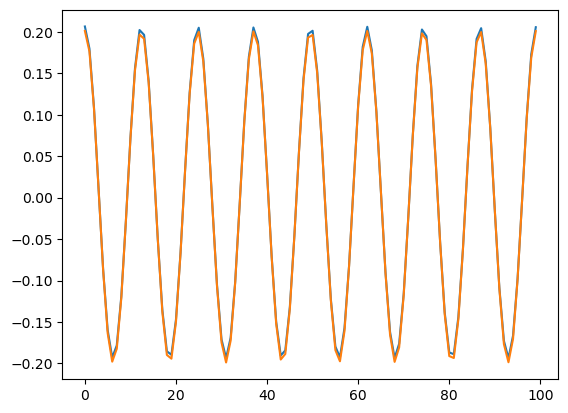

In [27]:
plt.plot(
    sim.observations[0].tod[0][:100]
)  # we chose det_0 to have 0 nonlinearity for reference
plt.plot(sim.observations[0].tod[1][:100])

In [28]:
binner_results = sim.make_binned_map(nside=nside)
binned = binner_results.binned_map

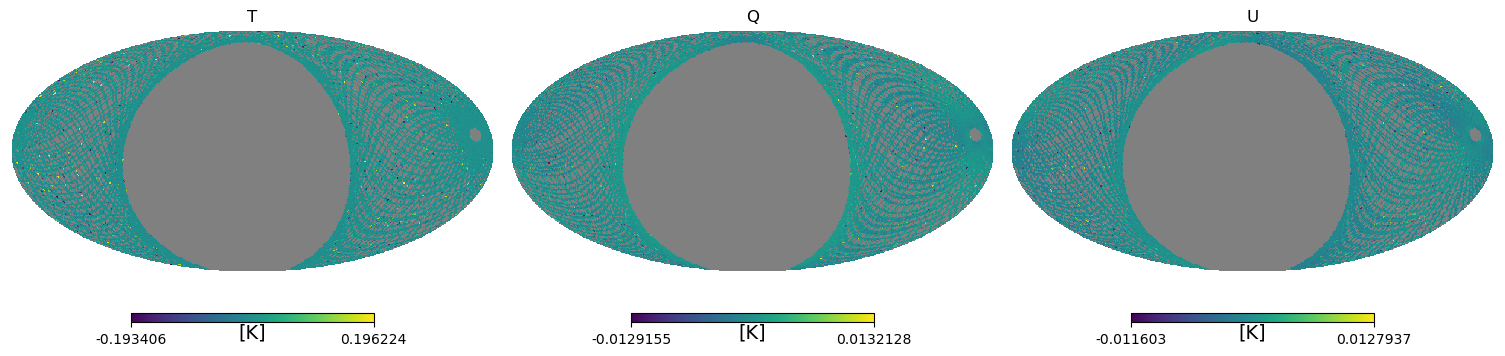

In [29]:
plt.figure(figsize=(15, 8))
hp.mollview(binned[0], sub=131, title="T", unit=r"[K]")
hp.mollview(binned[1], sub=132, title="Q", unit=r"[K]")
hp.mollview(binned[2], sub=133, title="U", unit=r"[K]")

We can see the effect on the Fourier transform as well:

In [30]:
f_nl0, psd_nl0 = periodogram(sim.observations[0].tod[1], 19)
f_nl1e3, psd_nl1e3 = periodogram(sim.observations[0].tod[0], 19)

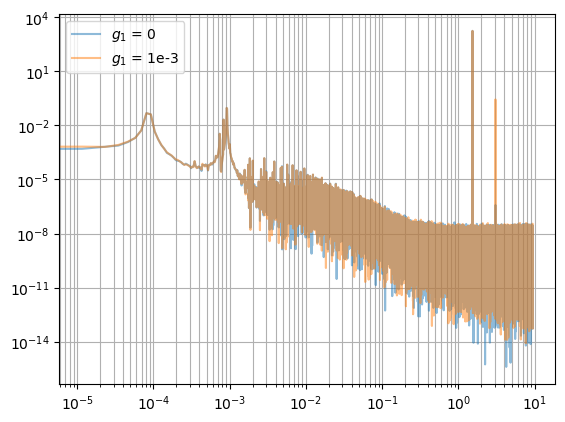

In [36]:
plt.loglog(f_nl0, psd_nl0, alpha=0.5, label=r"$g_1$ = 0")
plt.loglog(f_nl1e3, psd_nl1e3, alpha=0.5, label=r"$g_1$ = 1e-3")
plt.grid(which="both")
plt.legend()